In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

In [2]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
df=pd.read_csv('C:\\TensorFlow\\AAPL.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (755, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-06,107.9000,108.3000,107.5100,107.7000,102.6637,26880400
1,2016-09-07,107.8300,108.7600,107.0700,108.3600,103.2928,42364300
2,2016-09-08,107.2500,107.2700,105.2400,105.5200,100.5856,53002000
3,2016-09-09,104.6400,105.7200,103.1300,103.1300,98.3074,46557000
4,2016-09-12,102.6500,105.7200,102.5300,105.4400,100.5094,45292800


In [4]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
df["Open"] = pd.to_numeric(df["Open"],errors="coerce")

In [6]:
#no missing value
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df["Date"] = pd.to_datetime(df["Date"])


In [8]:
df["Year"] = df["Date"].apply(lambda x: x.year)
df["Month"] = df["Date"].apply(lambda x: x.month)
df["Quarter"] = df["Date"].apply(lambda x: x.quarter)
df["Day"] = df["Date"].apply(lambda x: x.day)

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Quarter,Day
0,2016-09-06,107.9000,108.3000,107.5100,107.7000,102.6637,26880400,2016,9,3,6
1,2016-09-07,107.8300,108.7600,107.0700,108.3600,103.2928,42364300,2016,9,3,7
2,2016-09-08,107.2500,107.2700,105.2400,105.5200,100.5856,53002000,2016,9,3,8
3,2016-09-09,104.6400,105.7200,103.1300,103.1300,98.3074,46557000,2016,9,3,9
4,2016-09-12,102.6500,105.7200,102.5300,105.4400,100.5094,45292800,2016,9,3,12


In [10]:
df=df.loc[:,['Date','Open', 'Year','Quarter','Month','Day']]

In [11]:
df.head()

,Date,Open,Year,Quarter,Month,Day
0,2016-09-06,107.9000,2016,3,9,6
1,2016-09-07,107.8300,2016,3,9,7
2,2016-09-08,107.2500,2016,3,9,8
3,2016-09-09,104.6400,2016,3,9,9
4,2016-09-12,102.6500,2016,3,9,12


In [12]:
df.sort_values('Date', inplace=True, ascending=True)
df = df.reset_index(drop=True)

In [13]:
df["weekday"]=df.apply(lambda row: row["Date"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [14]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.Date.min())
print('The time series ends on: ', df.Date.max())

Number of rows and columns after removing missing values: (755, 7)
The time series starts from:  2016-09-06 00:00:00
The time series ends on:  2019-09-05 00:00:00


The following data pre-processing and feature engineering need to be done before construct the LSTM model.

1. Create the dataset, ensure all data is float.

2. Normalize the features.

3. Split into training and test sets.

4. Convert an array of values into a dataset matrix.

5. Reshape into X=t and Y=t+1.

6. Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [128]:
dataset =  df["Open"].values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
print(dataset[:2,0])
dataset.shape

[107.9  107.83]


(755, 1)

In [129]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
trainSize =int(len(dataset)*.80)
testSize = len(dataset) - trainSize
train,test = dataset[0:trainSize,:],dataset[trainSize:len(dataset),:]
print(train.shape,test.shape)

(604, 1) (151, 1)


In [130]:
def seriesToSupervised(data,lookback=1):
    X,y = list(),list()
    for i in range(len(data)-lookback-1):
        xTemp = data[i:(i+lookback),0]
        yTemp = data[i+lookback,0]
        X.append(xTemp)
        y.append(yTemp)
    return np.array(X),np.array(y)
lookback= 30
x_train,y_train = seriesToSupervised(train,lookback)
x_test,y_test= seriesToSupervised(test,lookback)
print( x_train.shape,x_test.shape)

(573, 30) (120, 30)


In [131]:
# reshape input to be [samples, time steps, features]
x_train = x_train.reshape(573,1,30)
x_test = x_test.reshape(120,1,30)


In [132]:
#Model declaration
#Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Volume.
#The input shape will be 1 time step with 30 features.
model = Sequential()

model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2]))) #,return_sequences=True)

#model.add(LSTM(2))

model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

trModel = model.fit(x_train, y_train, epochs=20, batch_size=30, validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 573 samples, validate on 120 samples
Epoch 1/20
573/573 [==============================] - 2s 4ms/step - loss: 0.0191 - val_loss: 0.0181
Epoch 2/20
573/573 [==============================] - 0s 276us/step - loss: 0.0188 - val_loss: 0.0107
Epoch 3/20
573/573 [==============================] - 0s 260us/step - loss: 0.0102 - val_loss: 0.0061
Epoch 4/20
573/573 [==============================] - 0s 279us/step - loss: 0.0065 - val_loss: 0.0038
Epoch 5/20
573/573 [==============================] - 0s 260us/step - loss: 0.0056 - val_loss: 0.0036
Epoch 6/20
573/573 [==============================] - 0s 279us/step - loss: 0.0056 - val_loss: 0.0034
Epoch 7/20
573/573 [==============================] - 0s 297us/step - loss: 0.0045 - val_loss: 0.0035
Epoch 8/20
573/573 [==============================] - 0s 251us/step - loss: 0.0051 - val_loss: 0.0030
Epoch 9/20
573/573 [==============================] - 0s 264us/step - loss: 0.0043 - val_loss: 0.0029
Epoch 10/20
573/573 [=================

In [133]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(train_predict[:2,0])
print(y_train[:2])


[0.09564445 0.09937204]
[0.12120503 0.1139468 ]


In [134]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [135]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 4.783729061688224
Train Root Mean Squared Error: 5.826271225215644
Test Mean Absolute Error: 6.887375789056375
Test Root Mean Squared Error: 8.25170104185354


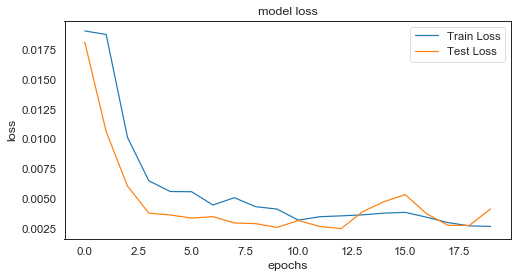

In [136]:
plt.figure(figsize=(8,4))
plt.plot(trModel.history['loss'], label='Train Loss')
plt.plot(trModel.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

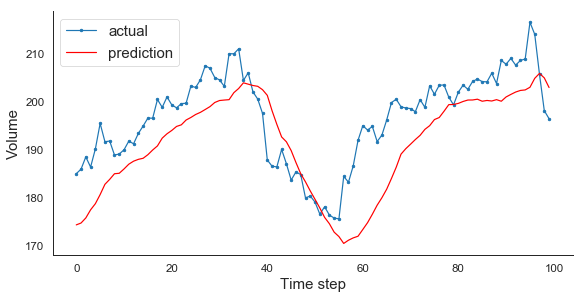

In [137]:
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Volume', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [138]:
#predicting over a new data input
new_input = np.array([118.18    , 117.25    , 116.860001, 116.809998, 117.099998,
       117.949997, 114.309998, 115.389999, 113.870003, 113.650002,
       113.459999, 111.400002, 110.980003, 108.529999, 110.080002,
       110.309998, 109.879997, 111.089996, 107.120003, 107.709999,
       106.57    , 106.699997, 109.809998, 109.720001, 110.120003,
       111.949997, 111.360001, 111.129997, 111.43    , 110.779999])


In [139]:

new_input= new_input.reshape(-1,1)
new_input = scaler.transform(new_input)
new_input = new_input.reshape(1,1,30)
new_input.shape


(1, 1, 30)

In [140]:
res = model.predict(new_input)
res = scaler.inverse_transform([res[0]])

In [141]:
res

array([[109.37048565]])